# Tutorial 03 – Machine Learning Pipeline

Today, we will be solving 2 classic machine learning tasks:
* classification - predicting a class from predefined set
* regression - predicting a value in a continuous range

And we will build our a machine learning pipeline in scikit-learn.

Real-world datasets are not "clean" - they contain features that have to be converted to other types, empty values (NaN), useless or misleading features, etc.

To deal with the imperfections in the dataset, we have to write some code that does the transforms. Pipelines allow the code to be reused on multiple datasets and easily swap machine learning models.

We will work with a real dataset that contains info about accidents in Brno in the year 2018. The source is [here](https://data.gov.cz/datov%C3%A1-sada?iri=https%3A%2F%2Fdata.gov.cz%2Fzdroj%2Fdatov%C3%A9-sady%2Fhttps---kod.brno.cz-api-action-package_show-id-dopravni-nehody).

In [1]:
import pandas as pd


def load_dataset():
    accidents = pd.read_csv(
        "https://www.fi.muni.cz/~xcechak1/IB031/datasets/accidents-brno.csv",
        parse_dates=["Date"],
    )
    accidents["WeekDay"] = accidents.Date.dt.weekday
    accidents["Month"] = accidents.Date.dt.month
    accidents["Day"] = accidents.Date.dt.day
    accidents["TotalHarmed"] = (
        accidents["DeathToll"] + accidents["HeavyInjuries"] + accidents["LightInjuries"]
    )
    return accidents


accidents = load_dataset()
accidents.head()

,ID,Date,Day,DayNight,Type,CausedBy,Alcohol,MainCause,DeathToll,HeavyInjuries,...,Weather,PlaceSituation,VehicleType,Skyd,Damage,X,Y,WeekDay,Month,TotalHarmed
0,60040180001,2018-01-02,2,Day,Other,Car driver,No,Inappropriate driving,0,0,...,Clear,None,Truck,No,0,-612803.712,-1156330.277,1,1,0
1,60040180002,2018-01-03,3,Day,Collision with a fixed obstacle,Car driver,No,Inappropriate speed,0,0,...,Snowing,None,Car,Yes,50000,-616665.499,-1151891.455,2,1,0
2,60040180003,2018-01-10,10,Day,Collision with other motor vehicle,Car driver,No,Inappropriate driving,0,0,...,Raining,None,Car,No,40000,-606674.259,-1161767.198,2,1,1
3,60040180004,2018-01-01,1,Night,Collision with other motor vehicle,Car driver,Not tested,Inappropriate driving,0,0,...,Clear,None,Car,No,20000,-608483.219,-1160770.721,0,1,1
4,60040180005,2018-01-13,13,Day,Collision with a fixed obstacle,Car driver,No,Inappropriate driving,0,0,...,Clear,None,Car,No,50000,-610224.050,-1159983.962,5,1,0


In [2]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7659 entries, 0 to 7658
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              7659 non-null   int64         
 1   Date            7659 non-null   datetime64[ns]
 2   Day             7659 non-null   int64         
 3   DayNight        7659 non-null   object        
 4   Type            7659 non-null   object        
 5   CausedBy        7659 non-null   object        
 6   Alcohol         7659 non-null   object        
 7   MainCause       7659 non-null   object        
 8   DeathToll       7659 non-null   int64         
 9   HeavyInjuries   7659 non-null   int64         
 10  LightInjuries   7659 non-null   int64         
 11  RoadCondition   7659 non-null   object        
 12  Weather         7659 non-null   object        
 13  PlaceSituation  7659 non-null   object        
 14  VehicleType     7659 non-null   object        
 15  Skyd

There is a total of 22 columns in the dataset, but 10 of them are of type `object`! Most of machine learning algorithms work with numerical or categorical data, but not with `object` columns. We will solve this problem by changing them to the `categorical` type.
A `categorical` columns takes on a fixed number of possible values (categories).

<div class="alert alert-block alert-warning"><b>Exercise 1</b></div>

Convert all columns of `object` type to categorical type.

In [3]:
object_cols = accidents.select_dtypes("object").columns
accidents[object_cols] = accidents[object_cols].astype("category")

OK, now check if the columns now have the type `category`.

In [4]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7659 entries, 0 to 7658
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ID              7659 non-null   int64         
 1   Date            7659 non-null   datetime64[ns]
 2   Day             7659 non-null   int64         
 3   DayNight        7659 non-null   category      
 4   Type            7659 non-null   category      
 5   CausedBy        7659 non-null   category      
 6   Alcohol         7659 non-null   category      
 7   MainCause       7659 non-null   category      
 8   DeathToll       7659 non-null   int64         
 9   HeavyInjuries   7659 non-null   int64         
 10  LightInjuries   7659 non-null   int64         
 11  RoadCondition   7659 non-null   category      
 12  Weather         7659 non-null   category      
 13  PlaceSituation  7659 non-null   category      
 14  VehicleType     7659 non-null   category      
 15  Skyd

All good. Now, let's stop before exploring the dataset more.

## Train/Test Split

When we train a model (this lecture, the model will be a decision tree), we want it to generalize well to unseen data, so it can predict something more than just labels from our training set. How to achieve that? We have to avoid two major issues in machine learning - *overfitting* and *underfitting*.

To even know if we are under/overfitting, we need to know how the model acts on unseen data. So we put aside a portion of our data (for example, 20%) and train the model on the rest. Then, we evaluate the model using metrics on the unseen data and see if they are as good as on the training set.

We have to do the split before getting statistics on the dataset - our brains are very good at pattern recognition and overfitting, and we could get a biased view on the underlying data distribution. Therefore, always do the train-test split before exploration analysis.

-------------

#### Intuition for underfitting / overfitting
If you want to get some more intuition about overfitting and capacity of a model, you can read this [article](https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765) with a nice explanation.

-------------

In [5]:
from sklearn.model_selection import train_test_split

train_set_orig, test_set_orig = train_test_split(
    accidents, test_size=0.2, random_state=42
)
print(f"Length of train set: {len(train_set_orig)}")
print(f"Length of test set:  {len(test_set_orig)}")

Length of train set: 6127
Length of test set:  1532


Now, we need to extract the column with value we want to predict. In the case of the `accidents` dataset, we will try to predict the value of the damage caused.

<div class="alert alert-block alert-warning"><b>Exercise 2</b></div>

Create two new variables `train_set` and `train_labels` with data from `train_set_orig`. `train_set` will contain all columns except **Damage** that we want to predict and `train_labels` will contain only single column **Damage**. Do the same for `test_set_orig`, `test_set`, and `test_labels`, respectively.

In [6]:
def get_labels(df, column="Damage"):
    labels = df[column]
    return df.drop(columns=[column]), labels


train_set, train_labels = get_labels(train_set_orig)
test_set, test_labels = get_labels(test_set_orig)

We are now ready to do exploratory analysis without getting bias on the full dataset.

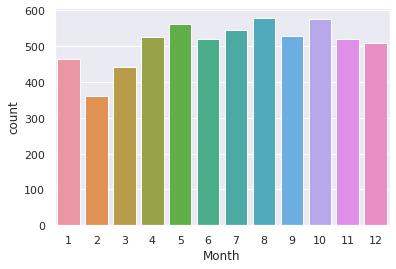

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()  # make plots prettier

sns.countplot(data=train_set, x="Month")

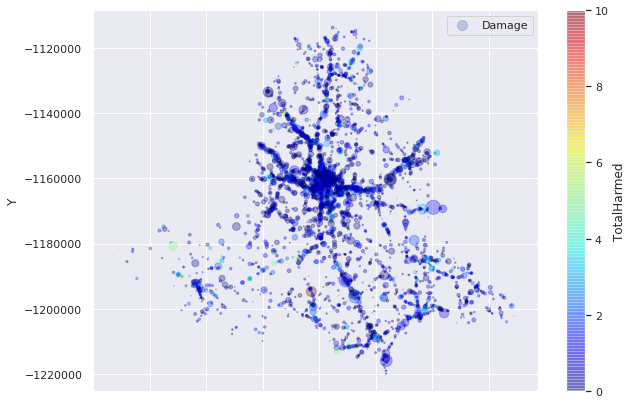

In [8]:
train_set.plot(
    kind="scatter",
    x="X",
    y="Y",
    alpha=0.3,
    s=train_labels / 5000,
    label="Damage",
    figsize=(10, 7),
    c="TotalHarmed",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
)

In [9]:
# TODO: here you can do your own analysis on the data

We are ready to work with the dataset. But, what if we want to do some preprocessing on the data - e.g., normalization? We would have to use the same preprocessing on both the train and test set and you have to do all your transformations twice and keep their order.

Here come [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) for the rescue! They allow you to write transforms once and then easily apply them to the test set. Even more, pipelines have methods for evaluating machine learning models and can be used with any model supported by `scikit-learn`.

#### Some useful pipeline methods
* `fit` - calculates parameters needed for transform
* `transform` - actually does the transform based on the calculated parameters
* `predict` - return predictions of the dataset (should be close to `train_labels` for `train_set`)
* `score` - calculate prediction score

We will create the pipeline for numerical features. Usual transformations include [imputation](https://scikit-learn.org/stable/modules/impute.html#impute) of missing values (NaN) and [standardization](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling), which scales every feature to zero mean $\mu = 0$ and unit variance $\sigma^2 = 1$.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("std_scaler", StandardScaler())]
)

To apply the `num_pipeline` on numerical features only, we have to use the [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) class.

In [11]:
from sklearn.compose import ColumnTransformer

num_features = train_set.select_dtypes("number").columns
pipeline = ColumnTransformer([("num", num_pipeline, num_features),])

In [12]:
pipeline.fit(train_set)
num_features_transformed = pipeline.transform(train_set)

print(f"Mean: {num_features_transformed.mean():.2f}")
print(f"Standard deviation: {num_features_transformed.std():.2f}")

Mean: -0.00
Standard deviation: 1.00


We can also transform the categorical features using a pipeline. The standard operation for categorical variables is [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - we encode each category into a new binary column. Each column then indicates the presence or absence of the given category.

<div class="alert alert-block alert-warning"><b>Exercise 3</b></div>

Create new pipeline for categorical variables, which will be composed of imputer and one-hot encoder. Then create a new pipeline which transforms both the numerical and the category variables using ColumnTransformer.

In [13]:
from sklearn.preprocessing import OneHotEncoder

cat_features = train_set.select_dtypes("category").columns
cat_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder())]
)

pipeline = ColumnTransformer(
    [("num", num_pipeline, num_features), ("cat", cat_pipeline, cat_features)]
)

In [14]:
train_set_transformed = pipeline.fit_transform(train_set)
train_set_transformed.shape  # should be (6127, 80) if the exercise was done correctly

(6127, 80)

## Decision trees

Now, we can use a machine learning model to learn how to predict the damage caused by an accident. We will use [decision trees](https://scikit-learn.org/stable/modules/tree.html), which can be used for both regression and classification tasks.

The algorithm used in `scikit-learn` is named `CART` and it is very similar to the `C4.5` decision tree algorithm used in lecture slides.

### Regression tree

In [15]:
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def print_score(y_true, y_pred):
    print("Predictions:", list(y_true[:10]), "...")
    print("Labels:     ", list(y_pred[:10]), "...")
    print(
        f"RMSE: {rmse(y_true, y_pred):.3f}"
    )  # calculate root mean square error (RMSE) of the regressor


reg_pipeline = Pipeline(
    [
        ("transform", pipeline),
        ("reg", DecisionTreeRegressor(criterion="mse", random_state=42)),
    ]
)

reg_pipeline.fit(train_set, train_labels)  # fit the training set
train_preds = reg_pipeline.predict(train_set)  # predict the labels based on train data
print_score(train_labels, train_preds)

Predictions: [10000, 0, 50000, 70000, 30000, 40000, 0, 0, 80000, 20000] ...
Labels:      [10000.0, 0.0, 50000.0, 70000.0, 30000.0, 40000.0, 0.0, 0.0, 80000.0, 20000.0] ...
RMSE: 2011.879


We trained a regressor that has a Root Mean Squared Error of ~2000 CZK on the training set for the damage caused. That should be pretty good, right? Well, let's try on the test set.

In [16]:
test_preds = reg_pipeline.predict(test_set)
print_score(test_labels, test_preds)

Predictions: [0, 60000, 10000, 20000, 0, 0, 30000, 150000, 15000, 15000] ...
Labels:      [0.0, 60000.0, 30000.0, 800000.0, 0.0, 0.0, 15000.0, 115000.0, 10000.0, 10000.0] ...
RMSE: 82546.194


Not so good results anymore. The tree *overfit* on the training data. We can use multiple methods to reduce overfitting - pruning, feature selection, model capacity.

<div class="alert alert-block alert-warning"><b>Exercise 4</b></div>

Try to train a `DecisionTreeRegressor` that has similar RMSE on both train and test set and lower than the previous test RMSE. Use some combination of parameters that minimizes the train and test RMSE. Try to get a test RMSE at least lower than 63000.

In [17]:
reg_pipeline = Pipeline(
    [
        ("transform", pipeline),
        (
            "reg",
            DecisionTreeRegressor(
                criterion="mse",
                splitter="best",
                max_depth=6,
                max_features=10,
                min_samples_split=30,
                random_state=42,
            ),
        ),
    ]
)
reg_pipeline.fit(train_set, train_labels)

train_preds = reg_pipeline.predict(train_set)
test_preds = reg_pipeline.predict(test_set)

print(rmse(train_preds, train_labels))
print(rmse(test_preds, test_labels))

49536.49843140378
61678.58119774441


### Classification tree

Classification trees are similar to regression trees, except they predict value from a fixed domain instead of a continuous value. We will use the accidents dataset once more to predict causes of accidents from the data.

In [18]:
def prepare_dataset(dataset, label_column="CausedBy"):
    labels = dataset[label_column]
    data = dataset.drop(
        columns=["ID", "Type", "MainCause", label_column]
    )  # drop columns which are very related to label
    return data, labels


train_set_clf, train_labels_clf = prepare_dataset(train_set)
test_set_clf, test_labels_clf = prepare_dataset(test_set)

<div class="alert alert-block alert-danger"><b>Exercise 5</b></div>

Now try to create a classification pipeline on your own. Try to use both numerical and categorical columns, use standard preprocessing and [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). You can use only some features or do more preprocessing (you can try PCA).

You are predicting the cause of the accident from other features. Do not overfit the training set and try to get an accuracy of 0.9. You can use [pipeline.score](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score) to get score of the model.

In [19]:
from sklearn.tree import DecisionTreeClassifier

num_features = train_set_clf.select_dtypes("number").columns
cat_features = train_set_clf.select_dtypes("category").columns

clf_pipeline = Pipeline(
    [
        (
            "transform",
            ColumnTransformer(
                [
                    # ("num", num_pipeline, num_features),
                    ("cat", cat_pipeline, cat_features),
                ]
            ),
        ),
        (
            "clf",
            DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=42),
        ),
    ]
)

In [20]:
clf_pipeline.fit(train_set_clf, train_labels_clf)

print(f"Train accuracy: {clf_pipeline.score(train_set_clf, train_labels_clf):.4f}")
print(f"Test accuracy : {clf_pipeline.score(test_set_clf, test_labels_clf):.4f}")

Train accuracy: 0.9233
Test accuracy : 0.9151


For classification tasks, accuracy is one of available metrics for quantifying the quality of predictions. But, it is not the only one. To see how our model predicts class by class, we can plot a confusion matrix.

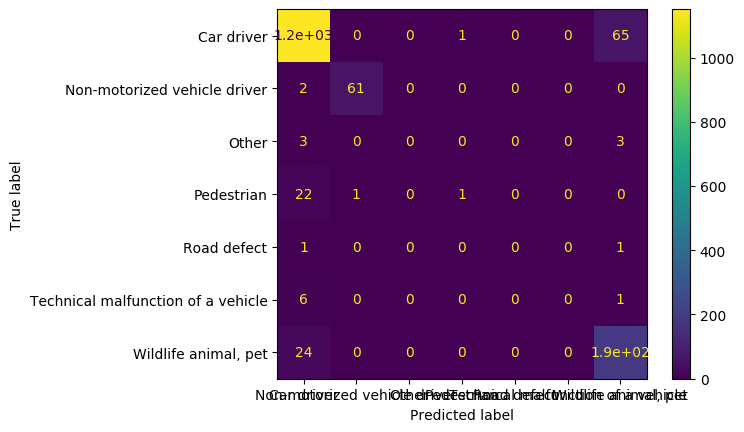

In [21]:
from sklearn.metrics import plot_confusion_matrix

sns.reset_orig()
plot_confusion_matrix(clf_pipeline, test_set_clf, test_labels_clf)

We can see the class imbalance in target variable here - on average, the accident is caused by the car driver (1200 samples). We can balance the class imbalance in confusion matrix by normalizing it.

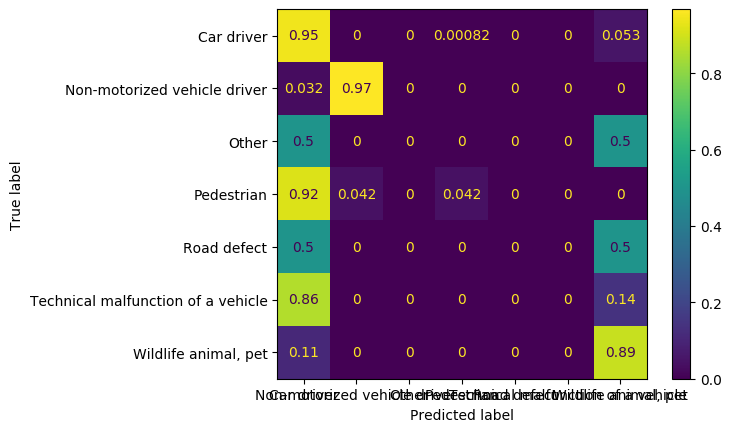

In [22]:
plot_confusion_matrix(clf_pipeline, test_set_clf, test_labels_clf, normalize="true")

For explaining the concept of the following metrics, imagine that for each label there are two classes - *positive* and *negative*. Positive means the sample is from that class, negative means it is from some other. It is quite similar to one-hot encoding.

* **True Positives (TP)** - sample is from positive class and predicted as positive
* **True Negatives (TN)** - sample is from negative class and predicted as negative
* **False Positives (FP)** - sample is from negative class and predicted as positive
* **False Negatives (FN)** - sample is from positive class and predicted as negative

When dealing with some machine learning problems, we want some of these metrics to be high and some do not matter that much - for example, when predicting a disease, the number of False Negatives should be as low as possible, even if there are some False Positives.

**Sensitivity** (true positive rate, recall) is percentage of correctly identified positives to all positives.  
**Specificity** (true negative rate) is percentage of correctly identified negatives to all negatives.  
**$F_1$-score** is a combination of precision and recall and is very often used when evaluating a model.

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

y_true = test_labels_clf
y_pred = clf_pipeline.predict(test_set_clf)

print("Precision = TP / (TP + FP)")
print(precision_score(y_true, y_pred, average="micro"))  # calculate total TP, FN, FP
print(
    precision_score(y_true, y_pred, average="macro", zero_division=0)
)  # calculate metrics for each class individually with same weight

print("\nRecall = TP / (TP + FN)")
print(recall_score(y_true, y_pred, average="micro"))
print(recall_score(y_true, y_pred, average="macro"))

print("\nF1 = 2 * (precision * recall) / (precision + recall)")
print(f1_score(y_true, y_pred, average="micro"))
print(f1_score(y_true, y_pred, average="macro"))

Precision = TP / (TP + FP)
0.9151436031331592
0.4522324522324523

Recall = TP / (TP + FN)
0.9151436031331592
0.4061446944635559

F1 = 2 * (precision * recall) / (precision + recall)
0.9151436031331592
0.4003796559191364
